In [1]:
!git clone https://github.com/zhixuhao/unet.git

fatal: destination path 'unet' already exists and is not an empty directory.


In [1]:
import torchvision
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

In [3]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

#### Data

In [2]:
## Configuration
in_channels = 1
out_channles = 1
img_size = 512
mask_size = 324
batch_size = 4

In [3]:
root = "./unet/data/membrane/train/"

In [4]:
images_list = os.listdir("./unet/data/membrane/train/image/")
labels_list = os.listdir("./unet/data/membrane/train/label/")

In [5]:
images = []
labels = []
for i in tqdm(range(len(images_list))):
    
    # read the image
    img = cv2.imread(os.path.join(root, "image", images_list[i]))
    label = cv2.imread(os.path.join(root, "label", labels_list[i]))
    
    # single channel gray scale image
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    label_gray = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
    
    img_gray = img_gray/255.
    label_gray = label_gray/255.

    # resize the image
    img_resized = cv2.resize(img_gray, (img_size, img_size))
    label_resized = cv2.resize(label_gray, (mask_size, mask_size))
    
    # add single channel
    img_resized = img_resized.reshape((1, img_resized.shape[0], img_resized.shape[1]))
    label_resized = label_resized.reshape((1, label_resized.shape[0], label_resized.shape[1]))
    
#     print(img_resized.shape)
    
    images.append(img_resized)
    labels.append(label_resized)

100%|██████████| 30/30 [00:00<00:00, 114.40it/s]


In [6]:
train = torch.utils.data.TensorDataset(torch.tensor(images, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32))
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=10, shuffle=True)

In [7]:
# print(labels[0][:10, :10])

#### Sample Visualization

In [8]:
x, y = next(iter(train_loader))

In [9]:
print(x.size(), y.size())

torch.Size([10, 1, 512, 512]) torch.Size([10, 1, 324, 324])


In [10]:
img_grid = torchvision.utils.make_grid(x.cpu(), nrow=1)
label_grid = torchvision.utils.make_grid(y.cpu(), nrow=1)

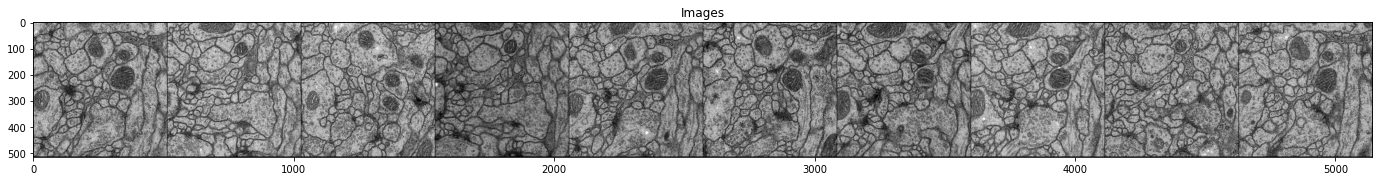

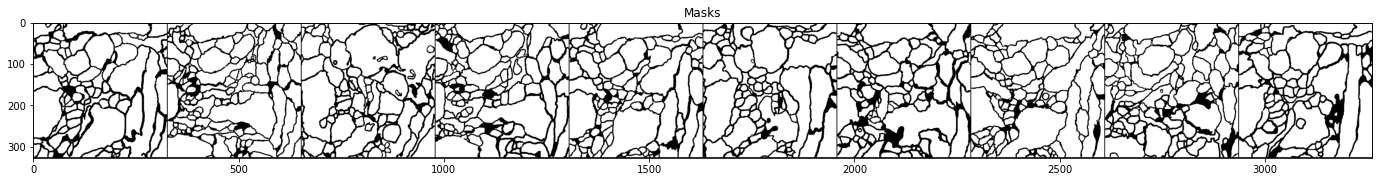

In [11]:
plt.figure(figsize=(24, 6))
plt.imshow(img_grid.permute(2, 1, 0))
plt.title("Images")
plt.figure(figsize=(24, 6))
plt.imshow(label_grid.permute(2, 1, 0))
plt.title("Masks")
plt.show()

#### Model

In [12]:
class UNet(nn.Module):
    
    def __init__(self):
        super(UNet, self).__init__()
        
        # In UNet double conv of kernel_size 3 is applied, each layer followed by ReLU activation then maxpooling 
        # is applied to reduce the feature map
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        # convolution operation -> Downsampling
        self.down_conv_1 = self.double_conv(in_channels=1, out_channels=64)
        self.down_conv_2 = self.double_conv(in_channels=64, out_channels=128)
        self.down_conv_3 = self.double_conv(in_channels=128, out_channels=256)
        self.down_conv_4 = self.double_conv(in_channels=256, out_channels=512)
        self.down_conv_5 = self.double_conv(in_channels=512, out_channels=1024)
        
        # transpose conv operation -> Upsamping
        self.up_conv_1 = self.deconv(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.up_conv_2 = self.deconv(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.up_conv_3 = self.deconv(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_conv_4 = self.deconv(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        # output layer to reduce output into single channel (gray scale image)
        self.output = self.deconv(in_channels=64, out_channels=2, kernel_size=1, stride=1)
    
    def forward(self, image):
#         print(image.size())
        
        # Encoder 
        x1 = self.down_conv_1(image) # fed to the last (nth) block
        x2 = self.maxpool(x1)
        
        x3 = self.down_conv_2(x2) # fed to the upsampling layer
        x4 = self.maxpool(x3)
        
        x5 = self.down_conv_3(x4) # fed to the upsampling layer
        x6 = self.maxpool(x5)
        
        x7 = self.down_conv_4(x6)# fed to the upsampling layer (latest)
        x8 = self.maxpool(x7)
        
        x9 = self.down_conv_5(x8)
        
        # Decoder
        x_8 = self.up_conv_1(x9)
        concat_1 = torch.cat((x_8, self.crop_tensor(x7, x_8)), dim=1)  
        x_7 = self.double_conv(in_channels=1024, out_channels=512)(concat_1)
        
        x_6 = self.up_conv_2(x_7)
        concat_2 = torch.cat((x_6, self.crop_tensor(x5, x_6)), dim=1)
        x_5 = self.double_conv(in_channels=512, out_channels=256)(concat_2)
        
        
        x_4 = self.up_conv_3(x_5)
        concat_3 = torch.cat((x_4, self.crop_tensor(x3, x_4)), dim=1)
        x_3 = self.double_conv(in_channels=256, out_channels=128)(concat_3)
        
        x_2 = self.up_conv_4(x_3)
        concat_3 = torch.cat((x_2, self.crop_tensor(x1, x_2)), dim=1)
        x_1 = self.double_conv(in_channels=128, out_channels=64)(concat_3)
        
        out = torch.nn.Sigmoid()(self.output(x_1))
        
        return out  
    
    ## 2 convolution block to increase the channels
    def double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3),
            nn.ReLU(inplace=True),
        )
        return conv
    
    ## 1 Transpose convolution to reduce the channels
    def deconv(self, in_channels, out_channels, kernel_size=1, stride=2):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
        )
    
    def crop_tensor(self, input_tensor, target_tensor):
        # tensor size [batch, channel, height, width]
        input_size = input_tensor.size(2)
        target_size = target_tensor.size(2)
        # if tagrte size is 56 and input size is 64 we need to crop 4 from both side
        # assuming input size will always be larger than the input
        delta = (input_size - target_size)//2
        
        # if delta is odd
        if delta < (input_size - target_size)/2:
            return input_tensor[:, :, delta:input_size-delta - 1, delta:input_size-delta - 1]
        else:
            return input_tensor[:, :, delta:input_size-delta, delta:input_size-delta]

#### Training

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
model = UNet()

In [15]:
## Trainable Parameters
sum(p.numel() for p in model.parameters() if p.requires_grad)

21628418

In [16]:
lr = 1e-2
epochs = 10

In [17]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
# writer = torch.utils.tensorboard.SummaryWriter()

#### Training Loop

In [ ]:
steps = 0
epoch_progress = tqdm(total=epochs, desc="Epoch", position=0)

for epoch in range(epochs):
    epoch_loss = []
    step_progress = tqdm(total=len(train_loader), desc="Step", position=0)
    for i, (inputs, labels) in enumerate(train_loader):
        
        # model = UNet().cuda()

        # inputs = inputs.cuda()
        # labels = labels.cuda()
        
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        # outputs.shape =(batch_size, n_classes, img_cols, img_rows)
        outputs = outputs.permute(0, 2, 3, 1)
        # outputs.shape =(batch_size, img_cols, img_rows, n_classes)
        m = outputs.shape[0]

        # print(inputs.size(), outputs.size())
        
        
        # labels = labels.resize(m*mask_size*mask_size)
        # outputs = outputs.resize(m*mask_size*mask_size)
        
        # labels = labels.type(torch.LongTensor)
        
        # print(outputs.size(), labels.size(), outputs.dtype, labels.dtype)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # writer.add_scalar("Step Loss", loss.item(), steps)
        if steps%5==0:
          print(f'Epoch {epoch} | Steps {steps} | Loss {loss.item()}')
        
        epoch_loss.append(loss.item())
        steps += 1
        step_progress.update(1)
        
    avg_loss = sum(epoch_loss)/len(epoch_loss)
    # writer.add_scalar("Epoch Loss", avg_loss, epoch)
    print(f"Epoch {epoch} | Loss {avg_loss}")

    epoch_progress.update(1)

In [ ]:
out = model(inputs)

In [ ]:
out.shape

In [ ]:
out = out.cpu()

In [ ]:
plt.imshow(out[8].detach().squeeze(), cmap="gray")

In [ ]:
x = inputs.cpu()

In [ ]:
plt.imshow(x[8].detach().squeeze(), cmap="gray")

#### Reference:
- UNet Paper: https://arxiv.org/pdf/1505.04597.pdf
- Membrane Dataset: https://www.kaggle.com/c/data-science-bowl-2018/data
- Abhishek Thakur's youtube video:  https://youtu.be/u1loyDCoGbE